In [1]:
import numpy as xp
from numpy.ma import masked_array
import matplotlib.pyplot as plt

from arte.types.mask import CircularMask

from ekarus.e2e.pyramid_wfs import PyramidWFS
from ekarus.e2e.detector import Detector
from ekarus.e2e.utils.create_field_from_zernike_coefficients import create_field_from_zernike_coefficients

In [2]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= xp.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

rad2arcsec = 180/xp.pi*3600
def compute_pixel_size(wavelength, pupil_diameter_in_m, padding=1):
    return wavelength/pupil_diameter_in_m*rad2arcsec/padding

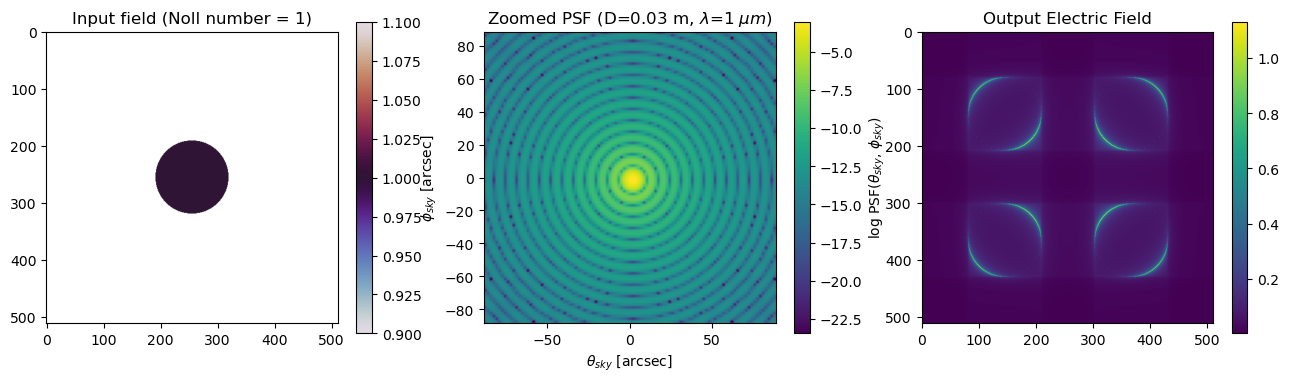

In [3]:
nx = 128

# Create pupil mask
oversampling = 4
mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)

# Conversions
pupilDiameterInM = 30e-3
lambdaInM = 1000e-9
pix2arcsec = compute_pixel_size(wavelength=lambdaInM, pupil_diameter_in_m=pupilDiameterInM, padding = oversampling)
pix2rad = pix2arcsec/rad2arcsec

# Create the input electric field for flat wavefront (a piston of 1 radians)
noll = 1
zern_amp = 1
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)

# Pyramid WFS
apex_angle = 0.0058 # vertex angle in radians, can be tricky to find the right value
wfs = PyramidWFS(apex_angle/pix2rad)

# Electric field propagation
output_field = wfs.propagate(input_field)
intensity = xp.abs(output_field**2)

# Compute normalized psf
psf = xp.abs(xp.abs(wfs.field_on_focal_plane**2))
psf *= 1/xp.sum(psf)

# Plotting results
s = 0.45
plt.figure(1, figsize=(16,9))
plt.subplot(1, 3, 1)
plt.title(f'Input field (Noll number = {noll})')
plt.imshow(xp.angle(input_field), cmap='twilight')
plt.colorbar(shrink=s)

plt.subplot(1, 3, 2)
showZoomCenter(psf, pix2arcsec, title=r'Zoomed PSF (D=%g m, $\lambda$=%g $\mu m$)' % (pupilDiameterInM, lambdaInM*1e6),
               xlabel=r'$\theta_{sky}$ [arcsec]', ylabel=r'$\phi_{sky}$ [arcsec]',
               zlabel=r'log PSF($\theta_{sky}$, $\phi_{sky}$)', shrink=0.45)
# plt.title("PSF on Focal Plane (Intensity) - Log Scale")
# plt.imshow(xp.log( psf ), cmap='inferno')
# plt.colorbar(shrink=s)

plt.subplot(1, 3, 3)
plt.title("Output Electric Field")
plt.imshow(intensity)
plt.colorbar(shrink=s)
plt.show()

In [4]:
diameter = 30e-3
alpha = 3*lambdaInM/diameter
print(alpha)

0.0001


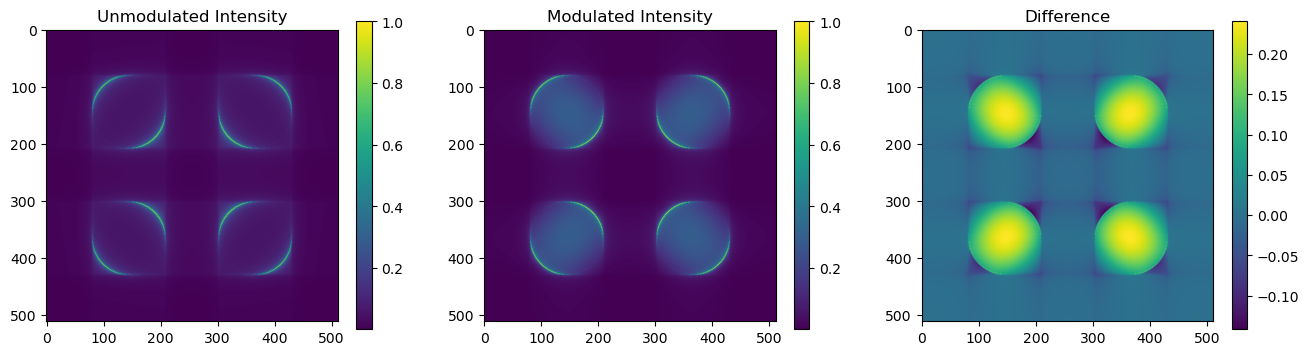

In [5]:
# repeat for a modulated pyramid WFS
diameter = 0.03
alpha = 3*lambdaInM/diameter

modulated_intensity = wfs.modulate(input_field, alpha/pix2rad, N_steps=16)

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title("Unmodulated Intensity")
plt.imshow(intensity/xp.max(intensity))
plt.colorbar(shrink=0.5)

plt.subplot(1,3,2)
plt.title("Modulated Intensity")
plt.imshow(modulated_intensity/xp.max(modulated_intensity))
plt.colorbar(shrink=0.5)

plt.subplot(1,3,3)
plt.title("Difference")
plt.imshow(modulated_intensity/xp.max(modulated_intensity)-intensity/xp.max(intensity))
plt.colorbar(shrink=0.5)


# slope = ccd.compute_slopes(modulated_intensity, Npix = 128)

# plt.figure()
# plt.plot(slope)
# plt.grid()

Text(0.5, 1.0, 'Masked Intensity D')

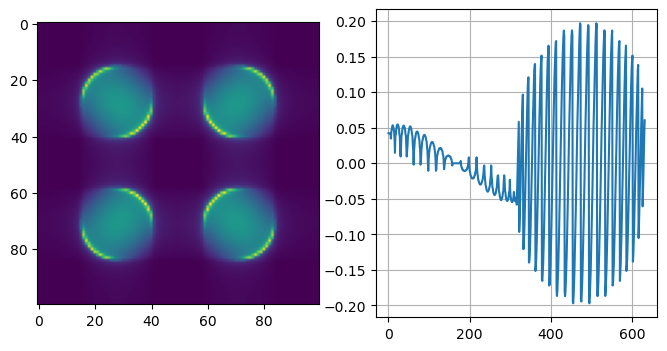

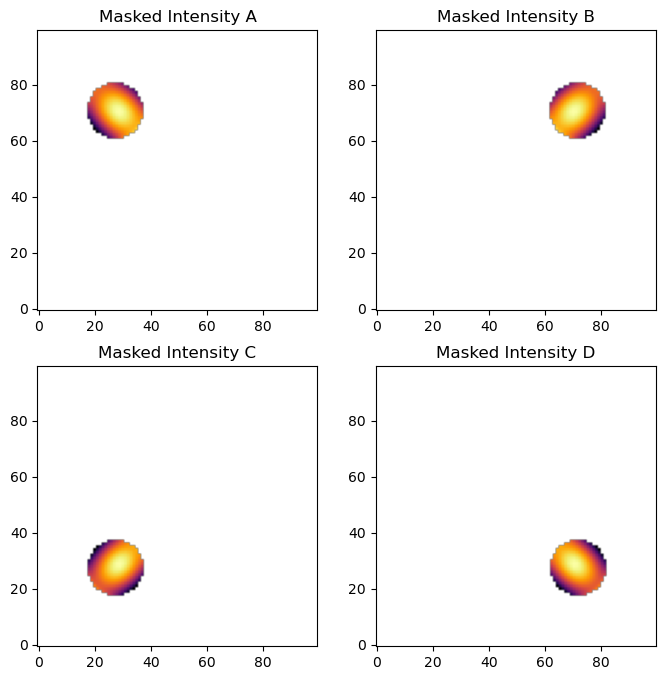

In [6]:
noll = 1
zern_amp = 1# 1e-4/pix2rad
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)

modulated_intensity = wfs.modulate(input_field, alpha/pix2rad, N_steps=24)

# Initialize detector
detector_shape = (100,100)
ccd = Detector(detector_shape=detector_shape)

detector_img = ccd.resize_intensity_on_detector(modulated_intensity)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(detector_img)

# Create subaperture masks
subaperture_masks = ccd.define_subaperture_masks(modulated_intensity, Npix = 20)
ccd_modulated_intensity = ccd.resize_intensity_on_detector(modulated_intensity)
slope = ccd.compute_slopes(modulated_intensity)

plt.subplot(1,2,2)
plt.plot(slope)
plt.grid()


plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.imshow(masked_array(ccd_modulated_intensity, mask=subaperture_masks[0]), origin='lower', cmap='inferno')
plt.title("Masked Intensity A")
plt.subplot(2, 2, 2)
plt.imshow(masked_array(ccd_modulated_intensity, mask=subaperture_masks[1]), origin='lower', cmap='inferno')
plt.title("Masked Intensity B")
plt.subplot(2, 2, 3)
plt.imshow(masked_array(ccd_modulated_intensity, mask=subaperture_masks[2]), origin='lower', cmap='inferno')
plt.title("Masked Intensity C")
plt.subplot(2, 2, 4)
plt.imshow(masked_array(ccd_modulated_intensity, mask=subaperture_masks[3]), origin='lower', cmap='inferno')
plt.title("Masked Intensity D")





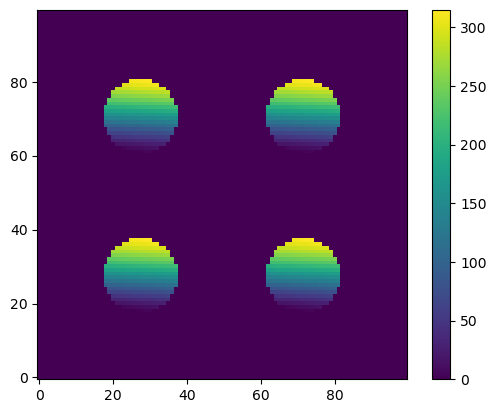

In [7]:

void_img = xp.zeros_like(ccd_modulated_intensity)
for i in range(4):
    void_img[xp.where(~ccd.subapertures[i])] = xp.arange(xp.sum(1-ccd.subapertures[i]))


plt.figure()
plt.imshow(void_img,origin='lower')
plt.colorbar()

In [8]:
# Compute slopes for Zernike modes
N = 9
Nmodes = (N-1)*(N-2)//2
IM = xp.zeros((int(xp.size(slope)),Nmodes))
mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)

rms_vec = xp.zeros(Nmodes)
zern_amp = 0.1
N0 = 2

for i in range(Nmodes):

    noll = N0 + i
    input_zern = create_field_from_zernike_coefficients(mask, noll, zern_amp)
    rms_vec[i] = xp.std(xp.angle(input_zern[~mask.mask()]))

    modulated_intensity = wfs.modulate(input_zern, alpha/pix2rad, N_steps=24)
    zern_slopes = ccd.compute_slopes(modulated_intensity, use_diagonal=False)

    # intensity = wfs.propagate(input_zern)
    # zern_slopes = ccd.compute_slopes(xp.abs(intensity**2))

    IM[:,i] = zern_slopes/zern_amp



Text(0, 0.5, 'STD [radians]')

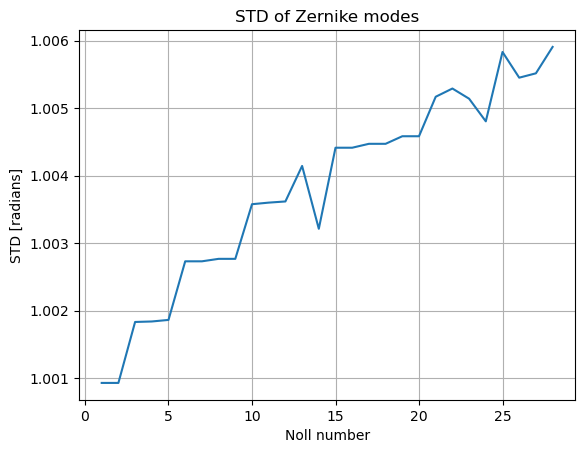

In [9]:
plt.figure()
plt.plot(xp.arange(Nmodes)+1,rms_vec/zern_amp)
plt.grid()
plt.title("STD of Zernike modes")
plt.xlabel("Noll number")
plt.ylabel("STD [radians]")

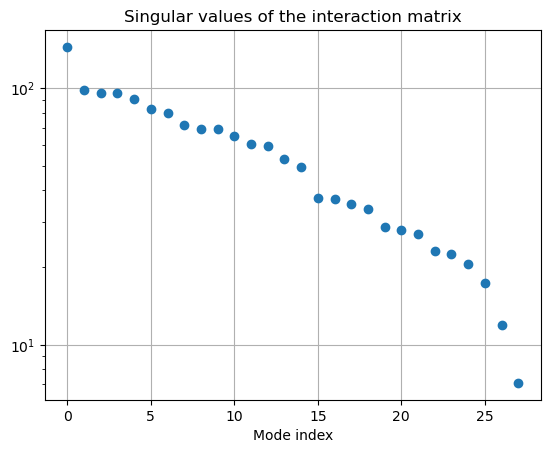

In [10]:
# SVD decomposition of the interaction matrix
U,S,V = xp.linalg.svd(IM, full_matrices=False)

plt.figure()
plt.plot(S,'o')
plt.grid()
plt.title("Singular values of the interaction matrix")
plt.xlabel("Mode index")
plt.yscale('log')

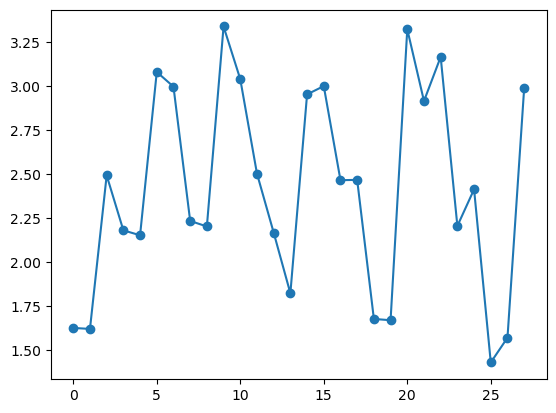

In [11]:
slope_std = xp.std(IM, axis = 0)

plt.figure()
plt.plot(slope_std,'-o')

In [12]:
# plt.figure()
# plt.plot(U[:,0])
# plt.title("First mode of the interaction matrix")

# plt.figure()
# plt.plot(U[:,-1])
# plt.title("Last mode of the interaction matrix")

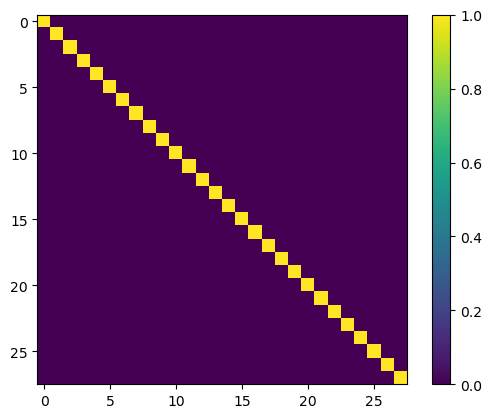

In [13]:
Sinv = 1/S
Rec = (V.T * Sinv) @ U.T

plt.figure()
plt.imshow(Rec @ IM)
plt.colorbar(cmap='inferno')

Text(0.5, 1.0, 'Measured intensity')

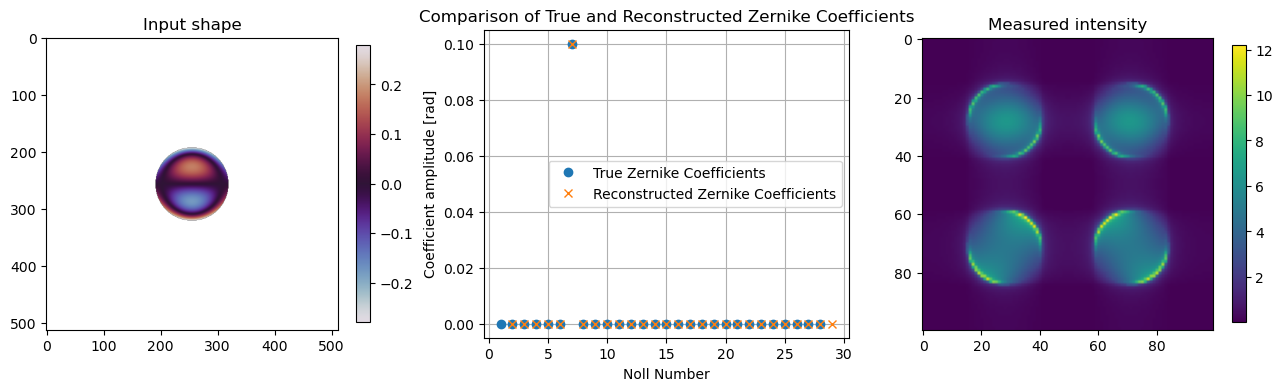

In [14]:
# Test the reconstructor
zids = 7
zamps = 0.1
zern_mix = create_field_from_zernike_coefficients(mask, zids, zamps)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(xp.ma.masked_array(xp.angle(zern_mix),mask=mask.mask()), cmap='twilight')
plt.colorbar(shrink=0.9)
plt.title('Input shape')

# Propagate the field through the WFS
# output_field = wfs.propagate(zern_mix/pix2rad)
# output_intensity = xp.abs(output_field**2)
output_intensity = wfs.modulate(zern_mix, alpha/pix2rad, N_steps=24)

# Compute slopes
slopes = ccd.compute_slopes(output_intensity,use_diagonal=False)

# Reconstruct the Zernike coefficients
zern_reconstructed = Rec @ slopes
rec_noll_ids = xp.arange(Nmodes)+N0

noll_ids = xp.arange(Nmodes)+1
true_zern = xp.zeros(Nmodes)
true_zern[xp.array(zids)-1] = zamps

plt.subplot(1,3,2)
plt.plot(noll_ids, true_zern, 'o', label='True Zernike Coefficients')
plt.plot(rec_noll_ids, zern_reconstructed, 'x', label='Reconstructed Zernike Coefficients')
plt.xlabel('Noll Number')
plt.ylabel('Coefficient amplitude [rad]')
plt.title('Comparison of True and Reconstructed Zernike Coefficients')
plt.legend(loc='best')
plt.grid()

ccd_intensity = ccd.resize_intensity_on_detector(output_intensity)

plt.subplot(1,3,3)
plt.imshow(ccd_intensity)
plt.colorbar(shrink=0.9)
plt.title('Measured intensity')


In [ ]:
def calibrate(Nmodes, Nsteps:int=16, useDiagonal:bool=False):
    
    IM = xp.zeros((int(xp.size(slope)),Nmodes))
    mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)

    zern_amp = 0.1

    for i in range(Nmodes):

        noll = 2 + i
        input_zern = create_field_from_zernike_coefficients(mask, noll, zern_amp)
        modulated_intensity = wfs.modulate(input_zern, alpha/pix2rad, N_steps=Nsteps)
        zern_slopes = ccd.compute_slopes(modulated_intensity, use_diagonal=useDiagonal)

        IM[:,i] = zern_slopes/zern_amp

    Rec = xp.linalg.pinv(IM)

    return Rec, IM

In [17]:
N = 9
Nmodes = (N-1)*(N-2)//2
Nsteps=24

Rec,IM = calibrate(Nmodes,Nsteps)

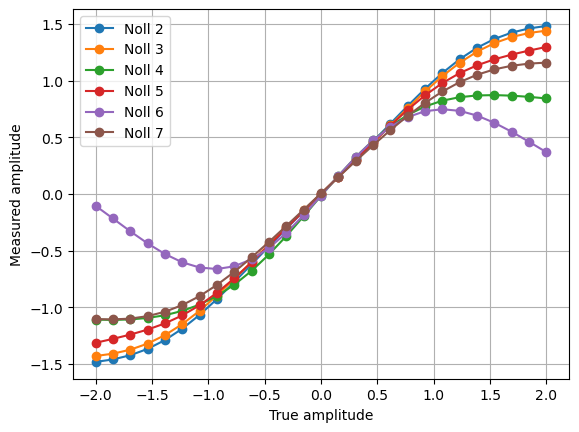

In [23]:
# Linearity check
Nmodes = 6

amp_vec = xp.linspace(-2,2,27,endpoint=True)
plt.figure()
intensities = xp.zeros((Nmodes,xp.shape(output_intensity)[0],xp.shape(output_intensity)[1]))

for j in range(Nmodes):

    zid = j + 2
    meas_amp = xp.zeros_like(amp_vec)

    for k,amp in enumerate(amp_vec):
        zern = create_field_from_zernike_coefficients(mask, zid, amp)
        output_intensity = wfs.modulate(zern, alpha/pix2rad, N_steps=24)
        slopes = ccd.compute_slopes(output_intensity,use_diagonal=False)
        zern_reconstructed = Rec @ slopes

        meas_amp[k] = zern_reconstructed[j]
    
    intensities[j,:,:] = output_intensity

    plt.plot(amp_vec, meas_amp,'-o', label=f'Noll {zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.grid(True)
        



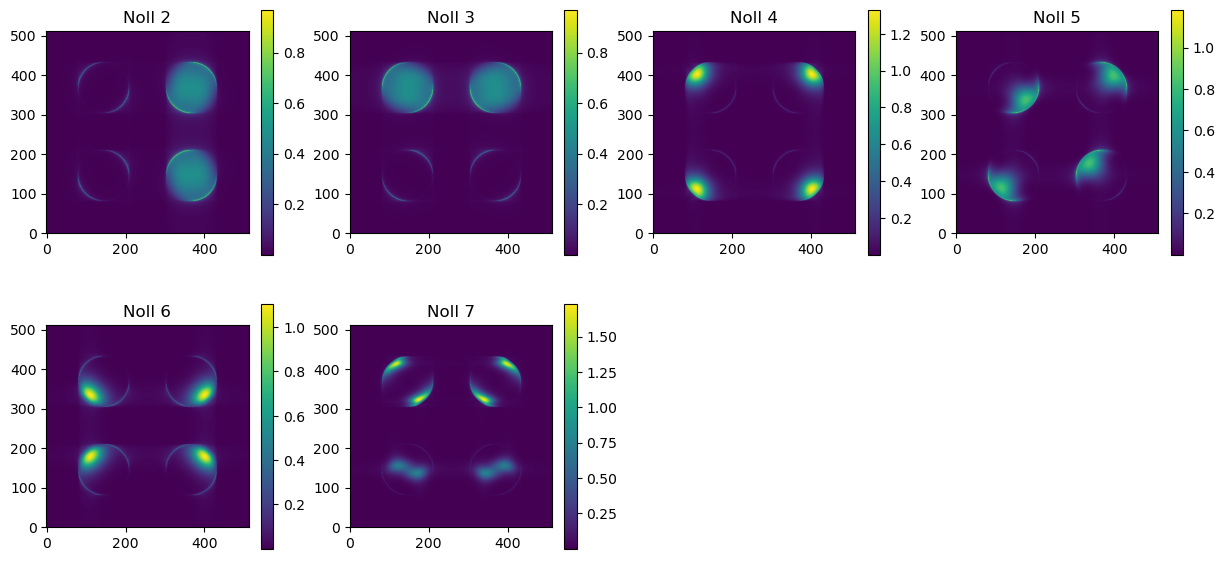

In [ ]:
# Plot the intensity on the detector for the last iteration

n_rows = Nmodes//4+1
plt.figure(figsize=(15,3.5*n_rows))
for i in range(Nmodes):
    plt.subplot(n_rows,4,i+1)
    plt.imshow(intensities[i,:,:],origin='lower')
    plt.colorbar()
    plt.title(f'Noll {i+2}')